In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path



In [9]:
project_name = "jailbreaks_qwen_v2"
eval_run_id = "test"

results_path = Path("../results") / project_name / "aggregated_results" / eval_run_id / f"evaluation_{eval_run_id}.csv"

df = pd.read_csv(results_path)

In [10]:

import re
import ast

def fully_robust_parser(s):
    # Remove newlines and normalize spaces
    s = re.sub(r'\s+', ' ', s.strip())
    # Remove brackets temporarily
    s_clean = s.strip('[]')
    # Add a comma between numbers that are not separated by a comma (handles floats like '1. 0.8')
    s_clean = re.sub(r'(?<=[\d.]) (?=[\d.-])', ', ', s_clean)
    # Wrap again in brackets
    s_clean = f'[{s_clean}]'
    return ast.literal_eval(s_clean)

# Apply the full fix
df["values_refusal"] = df["values_refusal"].apply(fully_robust_parser)
df["values_attempt"] = df["values_attempt"].apply(fully_robust_parser)

# Show result to confirm
df[["values_refusal", "values_attempt"]].head()

,values_refusal,values_attempt
0,"[0.5, 0.4, 0.66666667, 0.6, 0.33333333]","[0.75, 0.8, 0.66666667, 0.6, 1.0]"
1,"[1.0, 0.8, 0.8, 1.0, 0.8]","[0.33333333, 0.4, 0.4, 0.33333333, 0.6]"
2,"[0.25, 0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0, 1.0]"
3,"[0.0, 0.0, 0.33333333, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0, 1.0]"
4,"[0.4, 0.6, 0.4, 0.2, 0.6]","[0.8, 1.0, 0.8, 1.0, 1.0]"


In [23]:
from scipy.stats import norm

metric_name = "attempt"
alpha = 0.05
z = norm.ppf(1 - alpha / 2)
n = df["values_refusal"].apply(len)

confidence_level = 1-alpha

margin = z * df[f"std_{metric_name}"] / np.sqrt(n)

avg = df[f"avg_{metric_name}"]
std = df[f"std_{metric_name}"]

df[f"ci_upper_{metric_name}"] = df[f"avg_{metric_name}"] + margin

results_df = df[["method", "model", "benchmark", "evaluator"]]
results_df["avg"] = avg
results_df["std"] = std
results_df["ci_lower"] = avg - margin
results_df["ci_upper"] = avg + margin
results_df["ci_error"] = margin
results_df["n"] = n
results_df["confidence_level"] = confidence_level

/var/folders/qk/chlqbgnn41b0wjghf601kjxm0000gn/T/ipykernel_73305/3300930089.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df["avg"] = avg
/var/folders/qk/chlqbgnn41b0wjghf601kjxm0000gn/T/ipykernel_73305/3300930089.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df["std"] = std
/var/folders/qk/chlqbgnn41b0wjghf601kjxm0000gn/T/ipykernel_73305/3300930089.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [24]:
results_df

,method,model,benchmark,evaluator,avg,std,ci_lower,ci_upper,ci_error,n,confidence_level
0,prefixinjection-3,Qwen2.5-1.5B-Instruct,advbench-416,llama-v1,0.763333,0.136789,0.643435,0.883232,0.119898,5,0.95
1,baseline,Qwen2.5-1.5B-Instruct,advbench-416,llama-v1,0.413333,0.097980,0.327452,0.499215,0.085881,5,0.95
2,diffinmeans,Qwen2.5-1.5B-Instruct,advbench-416,llama-v1,1.000000,0.000000,1.000000,1.000000,0.000000,5,0.95
3,prefixinjection-3,Qwen2.5-3B-Instruct,advbench-416,llama-v1,1.000000,0.000000,1.000000,1.000000,0.000000,5,0.95
4,baseline,Qwen2.5-3B-Instruct,advbench-416,llama-v1,0.920000,0.097980,0.834119,1.005881,0.085881,5,0.95
5,diffinmeans,Qwen2.5-3B-Instruct,advbench-416,llama-v1,1.000000,0.000000,1.000000,1.000000,0.000000,5,0.95
6,prefixinjection-3,Qwen2-0.5B-Instruct,advbench-416,llama-v1,0.910000,0.111355,0.812395,1.007605,0.097605,5,0.95
7,baseline,Qwen2-0.5B-Instruct,advbench-416,llama-v1,0.200000,0.000000,0.200000,0.200000,0.000000,5,0.95
8,diffinmeans,Qwen2-0.5B-Instruct,advbench-416,llama-v1,0.880000,0.160000,0.739756,1.020244,0.140244,5,0.95


In [25]:
def plot_scores(
    df,
    metric_name: str,
    model_order: list = None,
    method_order: list = None,
    y_col: str = "avg",
    ci_col: str = "ci_error"
):
    
    # Sort df so bar positions match visual plot order
    df = df.copy()
    df["method"] = pd.Categorical(df["method"], categories=method_order, ordered=True)
    df["model"] = pd.Categorical(df["model"], categories=model_order, ordered=True)
    df = df.sort_values(["method", "model"])

    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")

    ax = sns.barplot(
        data=df,
        x="method",
        y=y_col,
        hue="model",
        hue_order=model_order,
        order=method_order,
        dodge=True,
        errorbar=None,
        capsize=0.1
    )

    # Add error bars manually
    for bars, model in zip(ax.containers, model_order or df["model"].unique()):
        model_rows = df[df["model"] == model]
        for bar, (_, row) in zip(bars, model_rows.iterrows()):
            x = bar.get_x() + bar.get_width() / 2
            ax.errorbar(
                x=x,
                y=row[y_col],
                yerr=row[ci_col],
                fmt='none',
                ecolor='black',
                capsize=3,
                linewidth=1
            )

    ax.set_ylabel(metric_name)
    ax.set_xlabel("Method")
    ax.set_title(f"{metric_name} with {df.confidence_level.iloc[0] * 100}% Confidence Intervals")
    plt.xticks(rotation=0)
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


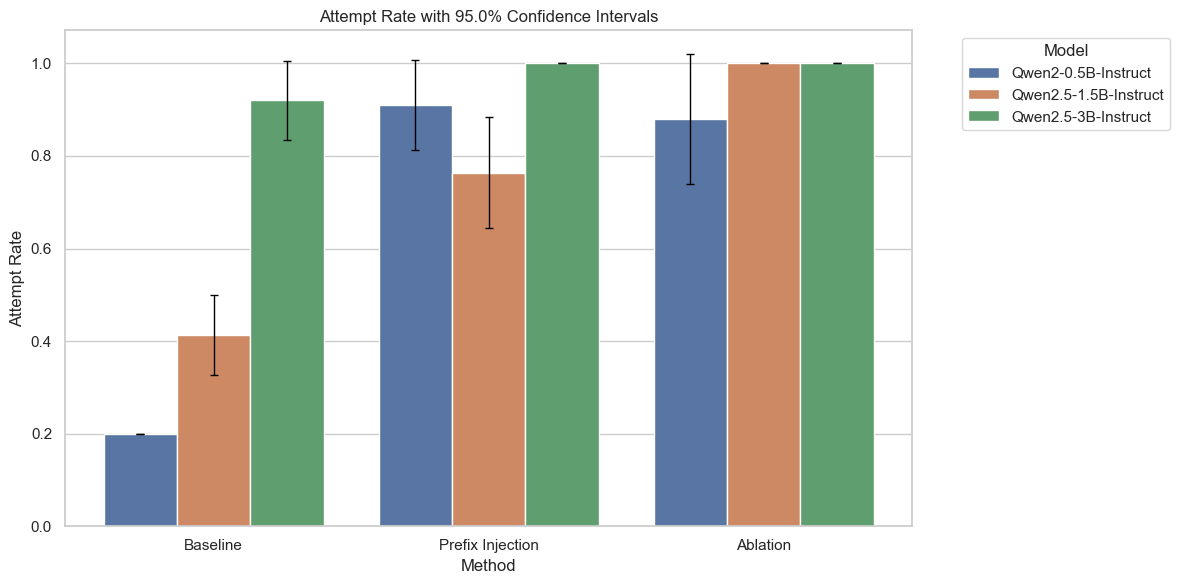

In [29]:
METHOD_1 = "Baseline"
METHOD_2 = "Prefix Injection"
METHOD_3 = "Ablation"

method_map = {
    "baseline": METHOD_1,
    "prefixinjection-3": METHOD_2,
    "diffinmeans": METHOD_3
}

plot_df = results_df.copy()

plot_df["method"] = results_df["method"].replace(method_map)

model_order = [
    "Qwen2-0.5B-Instruct",
    "Qwen2.5-1.5B-Instruct",
    "Qwen2.5-3B-Instruct",
]

method_order = [
    METHOD_1,
    METHOD_2,
    METHOD_3
]



plot_scores(plot_df, metric_name=f"{metric_name.capitalize()} Rate", model_order=model_order, method_order=method_order)

In [27]:
def plot_delta_from_baseline(df, model_order, method_order, baseline_method: str):
    baseline_df = df[df["method"] == baseline_method][["model", "avg"]]
    baseline_df = baseline_df.rename(columns={"avg": "baseline_avg"})

    delta_df = df.merge(baseline_df, on="model", how="left")

    # Compute change from baseline
    delta_df["delta"] = delta_df["avg"] - delta_df["baseline_avg"]
    delta_df = delta_df[delta_df["method"] != baseline_method]

    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")

    # Plot deltas (already computed)
    ax = sns.barplot(
        data=delta_df,
        x="method",
        y="delta",
        hue="model",
        hue_order=model_order,
        order=method_order,
        dodge=True,
        errorbar=None,
        capsize=0.1
    )

    ax.axhline(0, color="black", linestyle="--")
    ax.set_ylabel("Change in Refusal Score (Δ from Baseline)")
    ax.set_xlabel("Method")
    ax.set_title("Refusal Rate Change from Baseline")
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


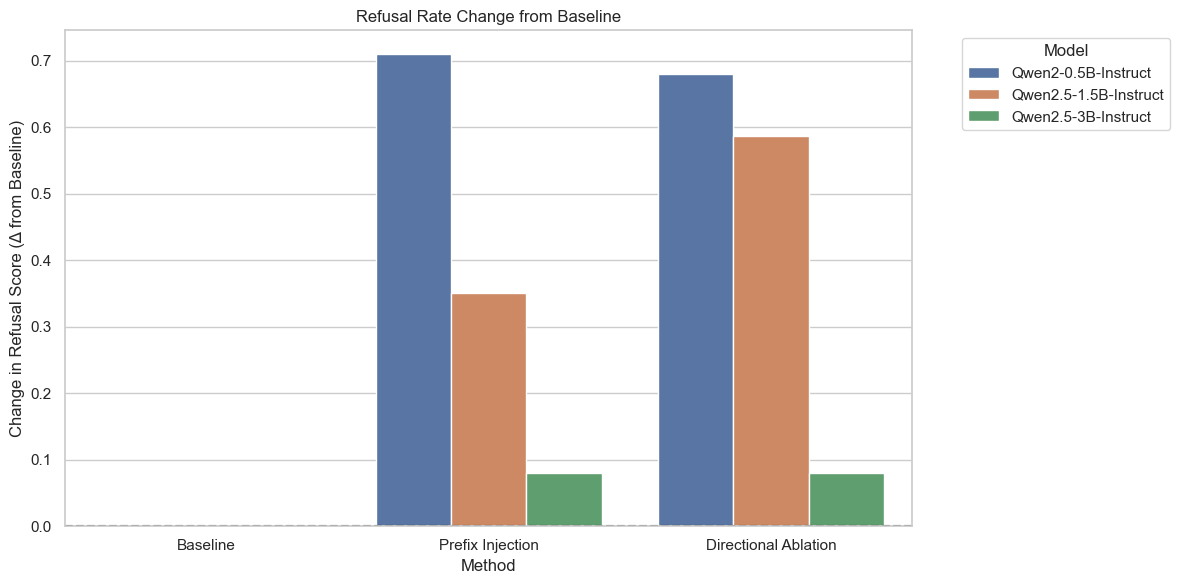

In [28]:
plot_delta_from_baseline(plot_df, model_order=model_order, method_order=method_order, baseline_method=METHOD_1)